In [138]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

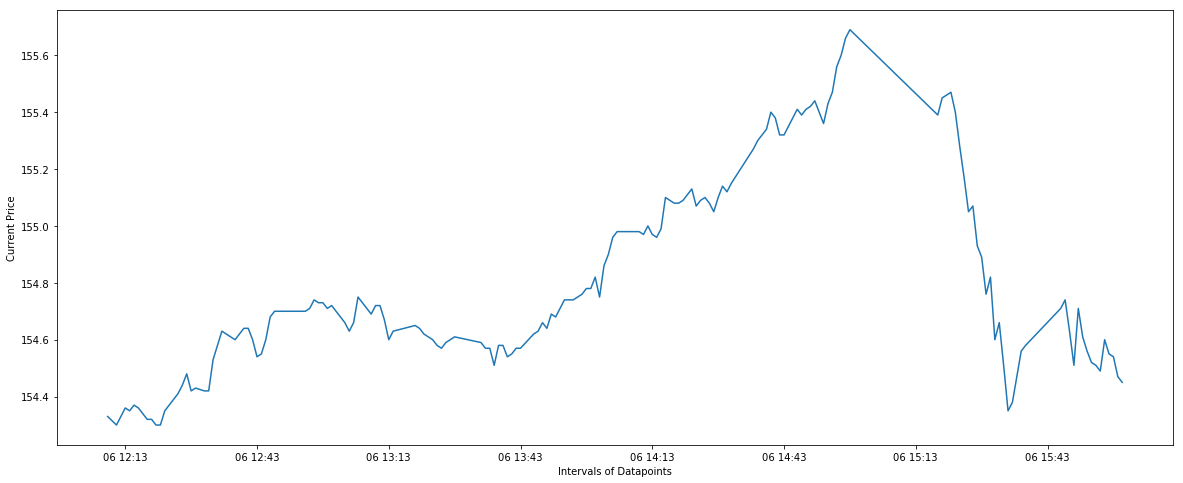

In [139]:
import pandas
import matplotlib.pyplot as plt
from dateutil.parser import parse
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 8

dataset1 = pandas.read_csv('edited.csv')
dataset1.drop(["variation", "Unnamed: 0", "previous_closeprice", "magnitude_change"], axis=1, inplace=True)
dataset1["time_stamps"]=dataset1["time_stamps"].map(lambda i: str(i))
dataset1["time_stamps"]=dataset1["time_stamps"].map(lambda i: parse(i))
#print dataset
dataset1  = dataset1.set_index(['time_stamps'])
plt.plot(dataset1.current_price)
plt.ylabel('Current Price')
plt.xlabel('Intervals of Datapoints')
plt.show()

In [140]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [141]:
# load the dataset
dataset1 = pandas.read_csv('edited.csv')
dataset1.drop(["variation", "Unnamed: 0", "previous_closeprice", "magnitude_change"], axis=1, inplace=True)
dataset1["time_stamps"]=dataset1["time_stamps"].map(lambda i: str(i))
dataset1["time_stamps"]=dataset1["time_stamps"].map(lambda i: parse(i))
dataset1  = dataset1.set_index(['time_stamps'])
dataset = dataset1.values
dataset = dataset.astype('float32')
#print dataset

In [142]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [143]:
# split into train and test sets
train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(101, 68)


In [144]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [145]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [146]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [147]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0471
Epoch 2/100
0s - loss: 0.0194
Epoch 3/100
0s - loss: 0.0126
Epoch 4/100
0s - loss: 0.0111
Epoch 5/100
0s - loss: 0.0102
Epoch 6/100
0s - loss: 0.0094
Epoch 7/100
0s - loss: 0.0086
Epoch 8/100
0s - loss: 0.0077
Epoch 9/100
0s - loss: 0.0068
Epoch 10/100
0s - loss: 0.0058
Epoch 11/100
0s - loss: 0.0049
Epoch 12/100
0s - loss: 0.0041
Epoch 13/100
0s - loss: 0.0033
Epoch 14/100
0s - loss: 0.0027
Epoch 15/100
0s - loss: 0.0021
Epoch 16/100
0s - loss: 0.0017
Epoch 17/100
0s - loss: 0.0013
Epoch 18/100
0s - loss: 0.0011
Epoch 19/100
0s - loss: 9.4753e-04
Epoch 20/100
0s - loss: 8.5347e-04
Epoch 21/100
0s - loss: 8.0123e-04
Epoch 22/100
0s - loss: 7.4976e-04
Epoch 23/100
0s - loss: 7.4281e-04
Epoch 24/100
0s - loss: 7.3530e-04
Epoch 25/100
0s - loss: 7.4925e-04
Epoch 26/100
0s - loss: 7.4064e-04
Epoch 27/100
0s - loss: 7.1873e-04
Epoch 28/100
0s - loss: 7.1868e-04
Epoch 29/100
0s - loss: 7.0666e-04
Epoch 30/100
0s - loss: 7.5331e-04
Epoch 31/100
0s - loss: 7.3370e

In [148]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.09 RMSE


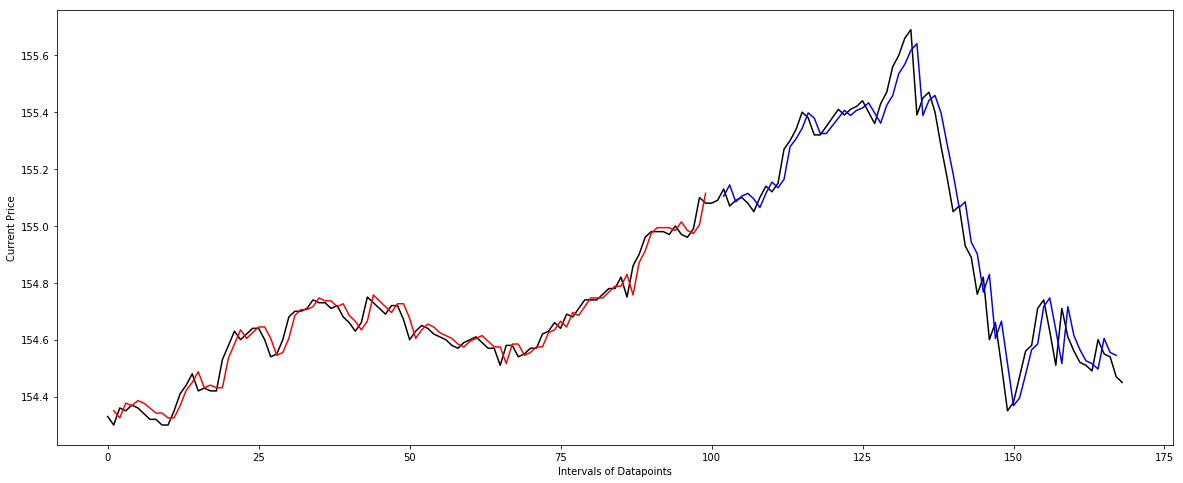

In [149]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color= "Black")
plt.plot(trainPredictPlot, color="Red")
plt.plot(testPredictPlot, color="Blue")
plt.ylabel('Current Price')
plt.xlabel('Intervals of Datapoints')
plt.show()